# Report of Heat equation's experiment

In [8]:
import torch
import torch.nn as nn
import numpy as np
import argparse
import tqdm
import os
import math
import matplotlib.pyplot as plt
import pathlib
import sys
from Solver.NRDE_Solver import PPDE_heat as PPDE_heat
from Solver.options import Heat
from pynvml import *

## Set up the configuration of resulting model

In [39]:
d=32
d_red=True
lstm_hid=9
d_after=4
mu=0.
sigma=1.
depth=2
hidden=15
ffn_hidden=30
output=1
num_layers=6
odestep=0.05
odesolver="midpoint"
withx=False
ncdrift=False
lag=10
T=1.
n_steps=100
model_dir='numerical_results\\Heat Equation\\mart\\model_32.tar'

## Load the model

In [40]:
heat = Heat(lag=lag,T=T,n_steps=n_steps)
model=PPDE_heat(d=d,d_red=d_red,lstm_hid=lstm_hid,d_after=d_after, mu=mu,sigma=sigma,depth=depth, hidden=hidden, ffn_hidden=ffn_hidden,output=output,num_layers=num_layers,odestep=odestep,odesolver=odesolver,withx=withx,ncdrift=ncdrift)
state=torch.load(model_dir)

In [41]:
device=0
model.load_state_dict(state["state"])
model.to(device)

PPDE_heat(
  (dim_red): RNN(
    (rnn): LSTM(32, 9, batch_first=True)
    (ffn): Sequential(
      (0): Linear(in_features=9, out_features=4, bias=True)
      (1): Identity()
    )
  )
  (f): NeuralRDE(
    (initial_linear): Linear(in_features=5, out_features=15, bias=True)
    (func): _NRDEFunc(
      (net): Sequential(
        (0): Linear(in_features=15, out_features=30, bias=True)
        (1): ReLU()
        (2): Linear(in_features=30, out_features=30, bias=True)
        (3): ReLU()
        (4): Linear(in_features=30, out_features=30, bias=True)
        (5): ReLU()
        (6): Linear(in_features=30, out_features=30, bias=True)
        (7): ReLU()
        (8): Linear(in_features=30, out_features=30, bias=True)
        (9): ReLU()
        (10): Linear(in_features=30, out_features=30, bias=True)
        (11): Tanh()
        (12): Linear(in_features=30, out_features=225, bias=True)
      )
    )
    (final_linear): Linear(in_features=15, out_features=1, bias=True)
  )
  (dfdx): NeuralR

## Generate some paths and plot against real solution.

In [22]:
##Define the true solution of Heat equation with our specific final condition.
def real_solu(d,t,x,T):
    z=torch.sum(torch.sum(x,2),1)*0.01
    y=torch.sum(x[:,-1,:],1)
    return torch.square(z)+2*(T-t)*y*z+(d/3)*(T-t)**3+(T-t)**2*(y**2)

##Generate X0
def sample_x0(batch_size, dim, device):
    
    x=0.2*torch.rand(batch_size,dim,device=device)
    y=torch.zeros(batch_size,dim,device=device)
    return y

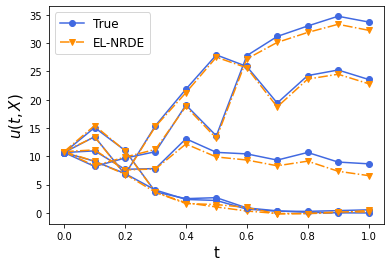

In [24]:
ts = torch.linspace(0,T,n_steps+1, device=device)
x0 = sample_x0(5,d,device=device)
with torch.no_grad():
    if d_red==True:
        x_copy,x,path_signature, _ =model.prepare_data(ts=ts,x0=x0,lag=lag,drop=False)
    else:
        x,path_signature, _ =model.prepare_data(ts=ts,x0=x0,lag=lag,drop=False)
tx=ts[::lag].reshape(1,-1,1).repeat(5,1,1)
x1=x[:,::lag,:]
x1=torch.cat([tx,x1],2)
pred_v=model.f((x1[:,0,:],path_signature))
pred=np.zeros([5,11,1])
true=np.zeros([5,11,1])
for idx, t in enumerate(ts[::lag]):
    pred[:,idx,:]=pred_v[:,idx,:].cpu().detach().numpy()
    if d_red==True:
        true[:,idx,:]=torch.squeeze(real_solu(d,t,x_copy[:,:(idx*lag)+1,:],T)).cpu().numpy().reshape((5,1))
    else:
        true[:,idx,:]=torch.squeeze(real_solu(d,t,x[:,:(idx*lag)+1,:],T)).cpu().numpy()
        
    
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(ts[::lag].cpu().numpy(), true[i,:,:], label="True",marker='o',color="royalblue")
    ax.plot(ts[::lag].cpu().numpy(), pred[i,:,:], '-.', label="EL-NRDE",marker='v',color="darkorange")
    
ax.set_ylabel(r"$u(t,X)$",fontsize=15)
ax.set_xlabel("t",fontsize=15)
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),fontsize=12)
fig_title="Heat"+"_"+str(d)+".png"

## Compute test metric

In [36]:
abs_error=np.zeros(10)
rel_error=np.ones(10)
test_num=100
for k in range(10):
    x0=sample_x0(test_num, d, device=device)
    with torch.no_grad():
        if d_red==True:
            x_copy,x,path_signature, _ =model.prepare_data(ts=ts,x0=x0,lag=lag,drop=False)
        else:
            x,path_signature, _ =model.prepare_data(ts=ts,x0=x0,lag=lag,drop=False)
    tx=ts[::lag].reshape(1,-1,1).repeat(test_num,1,1)
    x1=x[:,::lag,:]
    x1=torch.cat([tx,x1],2)
    Y=model.f((x1[:,0,:],path_signature))
    mc_pred=np.zeros(shape=(test_num,len(np.arange(0,101,lag)),1))
    pred=np.zeros(shape=(test_num,len(np.arange(0,101,lag)),1))
    for idx, t in enumerate(ts[::lag]):
        pred[:,idx,:]=Y[:,idx,:].cpu().detach().numpy()
        if d_red==True:
            mc_pred[:,idx,:]=torch.unsqueeze(real_solu(d,t,x_copy[:,:(idx*lag)+1,:],T),1).cpu().numpy()
        else:
            mc_pred[:,idx,:]=torch.unsqueeze(real_solu(d,t,x[:,:(idx*lag)+1,:],T),1).cpu().numpy()
    abs_err=np.sum(abs(pred-mc_pred))/(test_num*lag)
    abs_error[k]=abs_err
    rel_error[k]=abs_err/(np.sum(np.sum(mc_pred,axis=1))/test_num)
print("mean of abs err is",np.mean(abs_error))
print("std of abs err is",np.std(abs_error))
print("mean of rel err is",np.mean(rel_error))
print("std of rel err is",np.std(rel_error))

mean of abs err is 0.8428905944298858
std of abs err is 0.04038704073136887
mean of rel err is 0.007119793258295841
std of rel err is 0.0006125344369196439
